In [0]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

from matplotlib import pyplot
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve

**5 csv files A,B from separate data sources, will need to be merged as well as 'response' csv**


In [0]:
df_featuresGroupAlearning = pd.read_csv('featuresGroupAlearning.csv', sep=',')

df_featuresGroupAprediction = pd.read_csv('featuresGroupAprediction.csv', sep=',')

df_featuresGroupBlearning = pd.read_csv('featuresGroupBlearning.csv', sep=',')

df_featuresGroupBprediction = pd.read_csv('featuresGroupBprediction.csv', sep=',')

df_responseLearning = pd.read_csv('responseLearning.csv', sep=',')

**Check that all Ids are unique**

In [0]:
def check_unique(df):
    df_list = df['id'].tolist()
    
    flag = len(set(df_list)) == len(df_list)

    if(flag) : 
        print ("contains all unique id's") 
    else :  
        print ("does not contains all unique id's")

In [67]:
check_unique(df_featuresGroupAlearning)

contains all unique id's


In [68]:
check_unique(df_featuresGroupAprediction)

contains all unique id's


In [69]:
check_unique(df_featuresGroupBlearning)

contains all unique id's


In [70]:
check_unique(df_featuresGroupBprediction)

contains all unique id's


In [71]:
check_unique(df_responseLearning)

contains all unique id's


**Check Data Missingness**

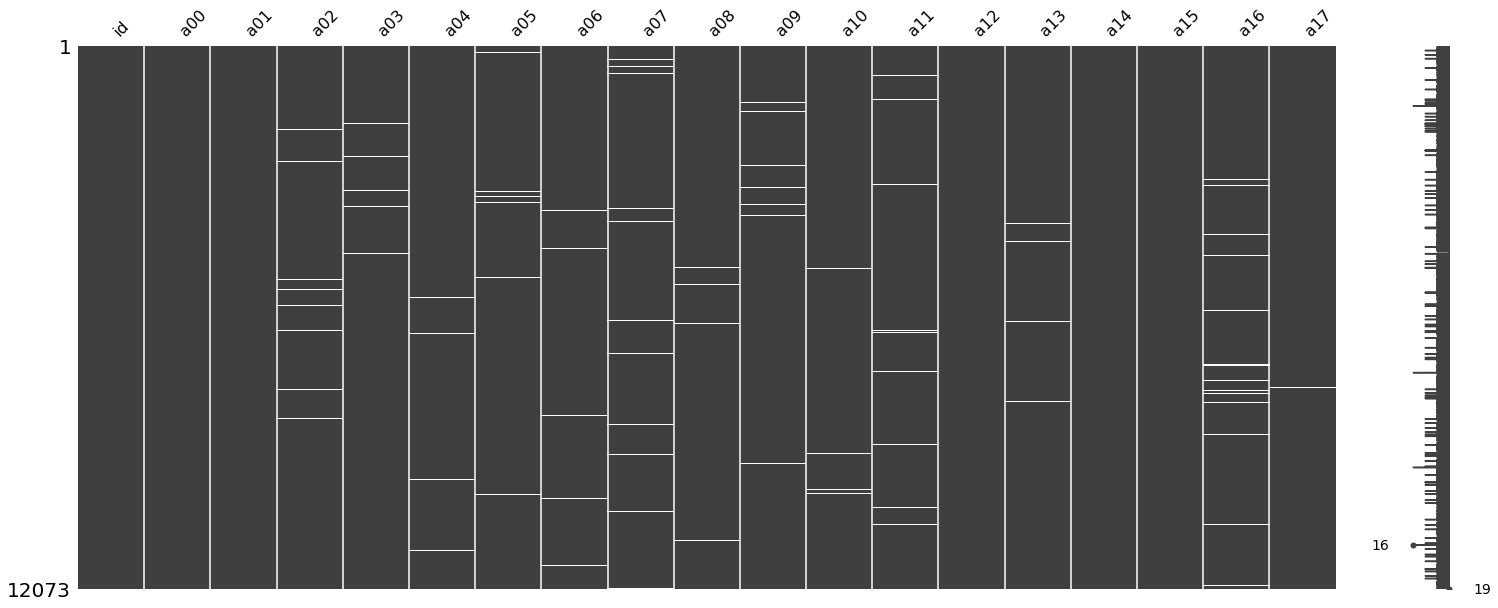

In [72]:
msno.matrix(df_featuresGroupAlearning) 

In [73]:
df_featuresGroupAlearning.isnull().sum() 

id       0
a00      4
a01      0
a02    128
a03    129
a04    133
a05    121
a06    122
a07    137
a08    115
a09    106
a10    102
a11    136
a12      3
a13    113
a14      2
a15      5
a16    128
a17    142
dtype: int64

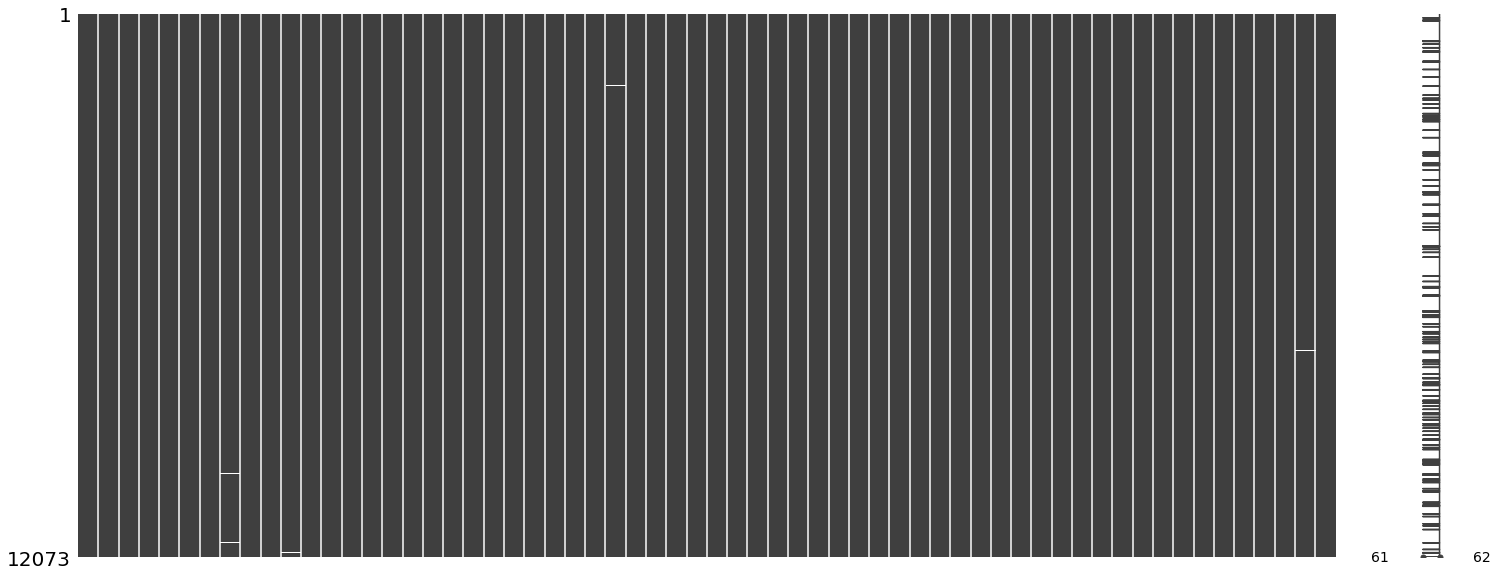

In [74]:
msno.matrix(df_featuresGroupBlearning) 

In [75]:
df_featuresGroupBlearning.isnull().sum() 

id      0
code    1
b00     3
b01     6
b02     2
       ..
b55     4
b56     2
b57     3
b58     4
zip     0
Length: 62, dtype: int64

**From this missingness graph we see no clear pattern in null data**

In [0]:
def nans(df): return df[df.isnull().any(axis=1)] #function to return null data

In [77]:
nans(df_responseLearning)

,id,y


**Combine Group A, Group B, Response Dataframes**

In [78]:
df_A_B_learning = pd.merge(left=df_featuresGroupAlearning, right=df_featuresGroupBlearning, left_on='id', right_on='id')
df_A_B_learning.shape

(12073, 80)

In [79]:
df_A_B_learn_response = pd.merge(left=df_A_B_learning, right=df_responseLearning, left_on='id', right_on='id')
df_A_B_learn_response.shape

(12073, 81)

In [80]:
df_A_B_prediction = pd.merge(left=df_featuresGroupAprediction, right=df_featuresGroupBprediction, left_on='id', right_on='id')
df_A_B_prediction.shape

(5366, 80)

**Check Data Types**

In [81]:
df_A_B_learn_response.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [82]:
df_A_B_learn_response.select_dtypes('object').head()

,id,b00,b21,b34,b35,b58
0,8181-59,$1560.56,Central,Wed.,0.01,June
1,7003-58,$892.23,Central,thu,-0.0%,Jun
2,8747-13,537.09,Central,Wednesday,0.01,june
3,1036-58,$634.36,Central,Wed.,-0.01,June
4,6205-73,-142.24,Central,Wednesday,0.0 %,jul


**Clean up non-standardized data entries**

**column: b00**

In [83]:
df_A_B_learn_response.b00.unique()

array(['$1560.56', '$892.23', '537.09', ..., '-990.07', '$-1693.33',
       '$ 1821.45'], dtype=object)

In [0]:
df_A_B_learn_response['b00'] = df_A_B_learn_response['b00'].astype(str)

df_A_B_learn_response['b00'] = df_A_B_learn_response['b00'].str.replace(' ', '')
df_A_B_learn_response['b00'] = df_A_B_learn_response['b00'].str.replace('$', '')

df_A_B_learn_response['b00'] = df_A_B_learn_response['b00'].astype(float)

In [85]:
df_A_B_learn_response['b00'].unique()

array([ 1560.56,   892.23,   537.09, ...,  -990.07, -1693.33,  1821.45])

**column: b21**

In [86]:
df_A_B_learn_response.b21.unique()

array(['Central', 'East', 'West', nan], dtype=object)

**column: b34**

In [87]:
df_A_B_learn_response.b34.unique()

array(['Wed.', 'thu', 'Wednesday', 'wednesday', 'Tuesday', 'Thursday',
       'thu.', 'Wed', 'tue', 'wed', 'Thu', 'Thu.', 'thursday', 'Fri',
       'Tue', 'fri', 'Tue.', 'friday', 'tue.', 'tuesday', 'Friday',
       'fri.', 'thurday', 'Fri.', 'Mon', 'mon.', nan, 'mon', 'Monday',
       'monday', 'Wendsday', 'wendsday'], dtype=object)

In [0]:
df_A_B_learn_response['b34'] = df_A_B_learn_response['b34'].astype(str)

df_A_B_learn_response['b34'] = df_A_B_learn_response['b34'].str.replace(' ', '')
df_A_B_learn_response['b34'] = df_A_B_learn_response['b34'].str.replace('.', '')

In [89]:
df_A_B_learn_response['b34'].unique()

array(['Wed', 'thu', 'Wednesday', 'wednesday', 'Tuesday', 'Thursday',
       'tue', 'wed', 'Thu', 'thursday', 'Fri', 'Tue', 'fri', 'friday',
       'tuesday', 'Friday', 'thurday', 'Mon', 'mon', 'nan', 'Monday',
       'monday', 'Wendsday', 'wendsday'], dtype=object)

**Create a function to clean up the various weekday typos**

In [0]:
def clean_weekdays(df,typos,day):
    df = df.replace(dict.fromkeys(typos, day))  
    return(df)

In [0]:
df_clean = df_A_B_learn_response

In [92]:
df_clean['b34'] = clean_weekdays(df_clean['b34'],['Mon','mon','Monday'], 'monday')
df_clean['b34'] = clean_weekdays(df_clean['b34'],['Tuesday','tue','Tue'], 'tuesday')
df_clean['b34'] = clean_weekdays(df_clean['b34'],['Wed','Wednesday','wed','Wendsday','wendsday'], 'wednesday')
df_clean['b34'] = clean_weekdays(df_clean['b34'],['thu','Thursday','Thu','thurday'], 'thursday')
df_clean['b34'] = clean_weekdays(df_clean['b34'],['Fri','fri','Friday'], 'friday')
df_clean['b34'].unique()

array(['wednesday', 'thursday', 'tuesday', 'friday', 'monday', 'nan'],
      dtype=object)

In [0]:
df_A_B_learn_response = df_clean

**column: b35**

In [94]:
df_A_B_learn_response.b35.unique()

array(['0.01', '-0.0%', '-0.01', '0.0 %', '-0.0 %', '-0.0', '-0.01 %',
       '0.01%', '0.01 %', '-0.01%', '-0.02', '0.02', '0.0%', '0.0',
       '-0.02%', '0.02%', '-0.02 %', '0.03', '0.02 %', '-0.03%', '0.04',
       '-0.03', '-0.03 %', '0.03%', '0.03 %', '-0.04', '-0.04 %', '0.04%',
       '-0.04%', nan], dtype=object)

In [95]:
df_A_B_learn_response['b35'] = df_A_B_learn_response['b35'].astype(str)

df_A_B_learn_response['b35'] = df_A_B_learn_response['b35'].str.replace(' ', '')
df_A_B_learn_response['b35'] = df_A_B_learn_response['b35'].str.replace('%', '')

df_A_B_learn_response['b35'] = df_A_B_learn_response['b35'].astype(float)

df_A_B_learn_response.b35.unique()

array([ 0.01, -0.  , -0.01, -0.02,  0.02,  0.03, -0.03,  0.04, -0.04,
         nan])

**column: b58**

In [96]:
df_A_B_learn_response.b58.unique()

array(['June', 'Jun', 'june', 'jul', 'aug', 'May', 'Oct', 'August',
       'sept.', 'august', 'sept', 'aug.', 'oct.', 'Aug.', 'oct', 'sep',
       'October', 'jun', 'Nov', 'Aug', 'Jun.', 'Sept.', 'Sep', 'sep.',
       'may', 'dec', 'April', 'september', 'Sep.', 'apr.', 'Apr', 'Oct.',
       'april', 'March', 'apr', 'october', 'dec.', 'Mar.', 'Mar', 'Apr.',
       'Nov.', 'November', 'nov.', 'jan', 'December', 'mar', 'Augest',
       'nov', 'march', 'mar.', nan, 'feb', 'Marhc', 'december', 'Feb',
       'Apirl', 'February', 'Feb.', 'jan.', 'november', 'feb.',
       'february'], dtype=object)

In [97]:
df_A_B_learn_response['b58'] = df_A_B_learn_response['b58'].astype(str)

df_A_B_learn_response['b58'] = df_A_B_learn_response['b58'].str.replace(' ', '')
df_A_B_learn_response['b58'] = df_A_B_learn_response['b58'].str.replace('.', '')

df_A_B_learn_response.b58.unique()

array(['June', 'Jun', 'june', 'jul', 'aug', 'May', 'Oct', 'August',
       'sept', 'august', 'oct', 'Aug', 'sep', 'October', 'jun', 'Nov',
       'Sept', 'Sep', 'may', 'dec', 'April', 'september', 'apr', 'Apr',
       'april', 'March', 'october', 'Mar', 'November', 'nov', 'jan',
       'December', 'mar', 'Augest', 'march', 'nan', 'feb', 'Marhc',
       'december', 'Feb', 'Apirl', 'February', 'november', 'february'],
      dtype=object)

**Create a function to clean up the month data**

In [0]:
def clean_months(df,typos,month):
    df = df.replace(dict.fromkeys(typos, month))  
    return(df)

In [99]:
df_clean['b58'] = clean_months(df_clean['b58'],['jan'], 'january')
df_clean['b58'] = clean_months(df_clean['b58'],['feb','Feb','February'], 'february')
df_clean['b58'] = clean_months(df_clean['b58'],['March','Mar','mar','Marhc'], 'march')
df_clean['b58'] = clean_months(df_clean['b58'],['April','apr','Apr','Apirl'], 'april')
df_clean['b58'] = clean_months(df_clean['b58'],['May'], 'may')
df_clean['b58'] = clean_months(df_clean['b58'],['June','Jun','jun'], 'june')
df_clean['b58'] = clean_months(df_clean['b58'],['jul'], 'july')
df_clean['b58'] = clean_months(df_clean['b58'],['August','aug','Aug','Augest'], 'august')
df_clean['b58'] = clean_months(df_clean['b58'],['sept','sep','Sept','Sep'], 'september')
df_clean['b58'] = clean_months(df_clean['b58'],['Oct','oct','October'], 'october')
df_clean['b58'] = clean_months(df_clean['b58'],['Nov','November','nov'], 'november')
df_clean['b58'] = clean_months(df_clean['b58'],['dec','December'], 'december')

df_clean['b58'].unique()

array(['june', 'july', 'august', 'may', 'october', 'september',
       'november', 'december', 'april', 'march', 'january', 'nan',
       'february'], dtype=object)

In [0]:
df_A_B_clean = df_clean

**Fill null entries in numerical columns with their column mean**

In [0]:
numerical_columns = df_A_B_clean.select_dtypes('float64','int64').columns.tolist()

In [0]:
df_clean = df_A_B_clean.fillna(df_A_B_clean[numerical_columns].mean())

**Convert categorical data to numeric 'dummy' variables**

**df_clean is dataframe with imputed null values**

**df_A_B_clean id dataframe with null values left in**

In [103]:
df_clean = pd.get_dummies(df_clean, columns=['b21'])
df_clean.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'code',
       'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09',
       'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19',
       'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30',
       'b31', 'b32', 'b33', 'b34', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40',
       'b41', 'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50',
       'b51', 'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'b58', 'zip', 'y',
       'b21_Central', 'b21_East', 'b21_West'],
      dtype='object')

In [104]:
df_A_B_clean = pd.get_dummies(df_A_B_clean, columns=['b21'])
df_A_B_clean.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'code',
       'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09',
       'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19',
       'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30',
       'b31', 'b32', 'b33', 'b34', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40',
       'b41', 'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50',
       'b51', 'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'b58', 'zip', 'y',
       'b21_Central', 'b21_East', 'b21_West'],
      dtype='object')

In [105]:
df_clean = pd.get_dummies(df_clean, columns=['b34'])
df_clean.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'code',
       'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09',
       'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19',
       'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30',
       'b31', 'b32', 'b33', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40', 'b41',
       'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50', 'b51',
       'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'b58', 'zip', 'y',
       'b21_Central', 'b21_East', 'b21_West', 'b34_friday', 'b34_monday',
       'b34_nan', 'b34_thursday', 'b34_tuesday', 'b34_wednesday'],
      dtype='object')

In [106]:
df_A_B_clean = pd.get_dummies(df_A_B_clean, columns=['b34'])
df_A_B_clean.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'code',
       'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09',
       'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19',
       'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30',
       'b31', 'b32', 'b33', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40', 'b41',
       'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50', 'b51',
       'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'b58', 'zip', 'y',
       'b21_Central', 'b21_East', 'b21_West', 'b34_friday', 'b34_monday',
       'b34_nan', 'b34_thursday', 'b34_tuesday', 'b34_wednesday'],
      dtype='object')

In [107]:
df_clean = pd.get_dummies(df_clean, columns=['b58'])
df_clean.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'code',
       'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09',
       'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19',
       'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30',
       'b31', 'b32', 'b33', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40', 'b41',
       'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50', 'b51',
       'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'zip', 'y', 'b21_Central',
       'b21_East', 'b21_West', 'b34_friday', 'b34_monday', 'b34_nan',
       'b34_thursday', 'b34_tuesday', 'b34_wednesday', 'b58_april',
       'b58_august', 'b58_december', 'b58_february', 'b58_january', 'b58_july',
       'b58_june', 'b58_march', 'b58_may', 'b58_nan', 'b58_november',
       'b58_october', 'b58_september'],
      dtype='object')

In [108]:
df_A_B_clean = pd.get_dummies(df_A_B_clean, columns=['b58'])
df_A_B_clean.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'code',
       'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09',
       'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19',
       'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30',
       'b31', 'b32', 'b33', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40', 'b41',
       'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50', 'b51',
       'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'zip', 'y', 'b21_Central',
       'b21_East', 'b21_West', 'b34_friday', 'b34_monday', 'b34_nan',
       'b34_thursday', 'b34_tuesday', 'b34_wednesday', 'b58_april',
       'b58_august', 'b58_december', 'b58_february', 'b58_january', 'b58_july',
       'b58_june', 'b58_march', 'b58_may', 'b58_nan', 'b58_november',
       'b58_october', 'b58_september'],
      dtype='object')

**Testing multicollinearity**

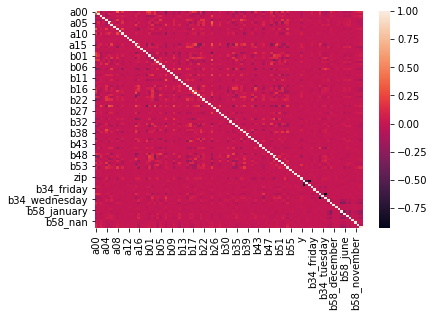

In [109]:
sns_corr_plot = sns.heatmap(df_clean.corr())
fig = sns_corr_plot.get_figure() 

**Lets check out the pairs of features with the highest correlation magnitudes**

In [0]:
def get_interaction_corr(corr, threshold):
   col_headers = corr.index.values
   for row in range(len(corr)):
       for col in range(row):
           if (corr.iloc[row, col] > threshold) or (corr.iloc[row, col] < -threshold):
               print("{}, {}: corr. = {}".format(col_headers[row], col_headers[col], corr.iloc[row, col]))

In [111]:
get_interaction_corr(df_clean.corr(),.5) 

b21_East, b21_Central: corr. = -0.5196841591192711
b21_West, b21_Central: corr. = -0.8241192940598852
b34_wednesday, b34_thursday: corr. = -0.9305235407914868


**Return the correlation measures associated with each feature and the target class**

In [112]:
df_clean[['b21_East', 'b21_Central', 'b21_West', 'b34_wednesday', 'b34_thursday', 'y']].corr()['y'][:]

b21_East        -0.008582
b21_Central     -0.009711
b21_West         0.017253
b34_wednesday    0.039089
b34_thursday    -0.046735
y                1.000000
Name: y, dtype: float64

**We see that of the highly correlated b21_West and b34_thursday are most correlated with the target class. These are the variables we will choose to keep**

In [0]:
df_clean = df_clean.drop(['b34_wednesday', 'b21_Central'], axis=1)

In [0]:
df_A_B_clean = df_A_B_clean.drop(['b34_wednesday', 'b21_Central'], axis=1)

**Data Modeling**

**Creating training/testing split with mean-imputed data**

In [0]:
y = df_clean['y']
X = df_clean.drop(['id','y'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 

**Creating training/testing split with data that contains null instances**

In [0]:
y_null = df_A_B_clean['y']
X_null = df_A_B_clean.drop(['id','y'],axis=1)

X_train_null, X_test_null, y_train_null, y_test_null = train_test_split(X_null, y_null, test_size = 0.2, random_state = 465) 

In [0]:
y_train.value_counts()

0    8645
1    1013
Name: y, dtype: int64

In [0]:
y_test.value_counts()

0    2161
1     254
Name: y, dtype: int64

**Logistic Regression Model**

In [0]:
log_reg_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [.001, .01, .1, 1.0],
    'class_weight': ['balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  
}

In [0]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats =3, random_state=1)

grid_log_reg = GridSearchCV(estimator=LogisticRegression(), param_grid=log_reg_params, verbose=5, cv=cv, n_jobs=5, scoring='roc_auc')

log_reg_result = grid_log_reg.fit(X_train, y_train)

Fitting 15 folds for each of 60 candidates, totalling 900 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 357 tasks      | elapsed: 10.9min
[Parallel(n_jobs=5)]: Done 587 tasks      | elapsed: 20.5min
[Parallel(n_jobs=5)]: Done 900 out of 900 | elapsed: 30.2min finished


In [0]:
print("Best AUC: %f using %s" % (log_reg_result.best_score_, log_reg_result.best_params_))

Best AUC: 0.869216 using {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}


In [0]:
lr = LogisticRegression(C=1.0, class_weight='balanced', penalty='l2', solver='newton-cg')

lr.fit(X_train, y_train)

y_train_pred_logreg = lr.predict(X_train)

In [0]:
print(classification_report(y_train, y_train_pred_logreg))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88      8645
           1       0.32      0.80      0.45      1013

    accuracy                           0.80      9658
   macro avg       0.64      0.80      0.67      9658
weighted avg       0.90      0.80      0.83      9658



**Visualization for the confusion matrix**

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric on the train dataset: 79.86179664363277%



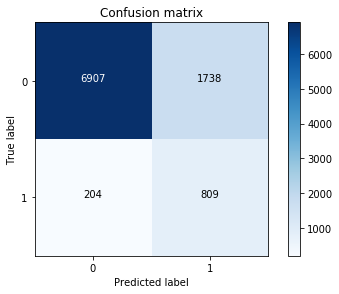

In [0]:
cnf_matrix_tra = confusion_matrix(y_train, y_train_pred_logreg)

print("Recall metric on the train dataset: {}%\n".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [0]:
lr.fit(X_test, y_test)

y_test_pred_logreg = lr.predict(X_test)

In [0]:
print(classification_report(y_test, y_test_pred_logreg))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      2161
           1       0.36      0.84      0.51       254

    accuracy                           0.83      2415
   macro avg       0.67      0.83      0.70      2415
weighted avg       0.91      0.83      0.85      2415



Recall metric on the train dataset: 83.85826771653544%



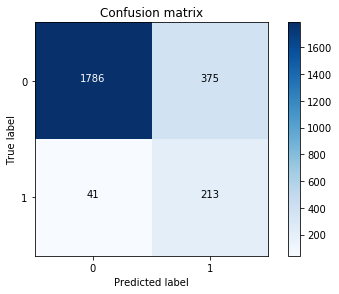

In [0]:
cnf_matrix_tra = confusion_matrix(y_test, y_test_pred_logreg)

print("Recall metric on the train dataset: {}%\n".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

**Visualize the ROC curve and AUC score**

Logistic: ROC AUC=0.911


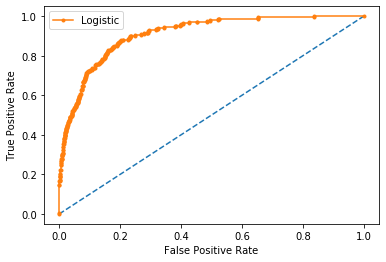

In [0]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

**XGB Model**

In [0]:
import collections

# count examples in each class
counter = collections.Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 8.534


In [0]:
xgbc_params = {
    'scale_pos_weight': [4, 8.534, 10],
    'booster': ['gbtree','dart'],
    'max_depth': [4, 6, 12],
    'lambda': [.01, .1, 1],
    'alpha': [0, .001, .01]
}

In [0]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

grid_xgbc = GridSearchCV(estimator=XGBClassifier(), param_grid=xgbc_params, n_jobs=5, verbose=5, cv=cv, scoring='roc_auc')

xgbc_result = grid_xgbc.fit(X_train, y_train)

Fitting 15 folds for each of 162 candidates, totalling 2430 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   39.7s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.6min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 15.4min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 29.2min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 45.6min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 71.3min
[Parallel(n_jobs=5)]: Done 872 tasks      | elapsed: 100.3min
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed: 127.8min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed: 166.4min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 208.3min
[Parallel(n_jobs=5)]: Done 2168 tasks      | elapsed: 253.0min
[Parallel(n_jobs=5)]: Done 2430 out of 2430 | elapsed: 288.3min finished


In [0]:
print("Best: %f using %s" % (xgbc_result.best_score_, xgbc_result.best_params_))

Best: 0.952664 using {'alpha': 0, 'booster': 'gbtree', 'lambda': 0.01, 'max_depth': 12, 'scale_pos_weight': 10}


In [0]:
xgbc = XGBClassifier(alpha=0, booster='gbtree', reg_lambda=1, max_depth=12, scale_pos_weight=10)

xgbc.fit(X_train, y_train)

y_train_pred_xgbc = xgbc.predict(X_train)

In [0]:
print(classification_report(y_train, y_train_pred_xgbc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8645
           1       1.00      1.00      1.00      1013

    accuracy                           1.00      9658
   macro avg       1.00      1.00      1.00      9658
weighted avg       1.00      1.00      1.00      9658



**Modeling training partition containing null data**

In [0]:
xgbc_null = XGBClassifier(alpha=0, booster='gbtree', reg_lambda=1, max_depth=12, scale_pos_weight=10)

xgbc_null.fit(X_train_null, y_train_null)

y_train_pred_xgbc_null = xgbc_null.predict(X_train_null)

In [0]:
print(classification_report(y_train_null, y_train_pred_xgbc_null))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8645
           1       1.00      1.00      1.00      1013

    accuracy                           1.00      9658
   macro avg       1.00      1.00      1.00      9658
weighted avg       1.00      1.00      1.00      9658



Recall metric on the training dataset: 100.0%



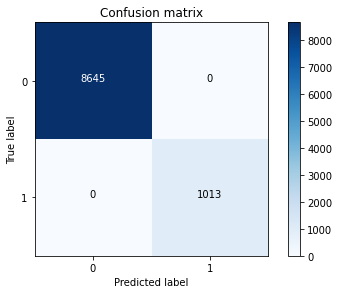

In [0]:
cnf_matrix_tra = confusion_matrix(y_train, y_train_pred_xgbc)

print("Recall metric on the training dataset: {}%\n".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [0]:
xgbc.fit(X_test, y_test)

y_test_pred_xgbc = xgbc.predict(X_test)

In [0]:
print(classification_report(y_test, y_test_pred_xgbc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2161
           1       1.00      1.00      1.00       254

    accuracy                           1.00      2415
   macro avg       1.00      1.00      1.00      2415
weighted avg       1.00      1.00      1.00      2415



**Modeling testing partition containing null data**

In [0]:
xgbc_null.fit(X_test_null, y_test_null)

y_test_pred_xgbc_null = xgbc_null.predict(X_test_null)

In [0]:
print(classification_report(y_test_null, y_test_pred_xgbc_null))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2161
           1       1.00      1.00      1.00       254

    accuracy                           1.00      2415
   macro avg       1.00      1.00      1.00      2415
weighted avg       1.00      1.00      1.00      2415



Recall metric on the testing dataset: 100.0%



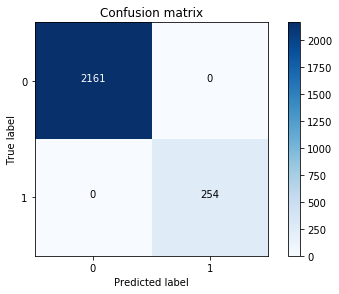

In [0]:
cnf_matrix_tra = confusion_matrix(y_test, y_test_pred_xgbc)

print("Recall metric on the testing dataset: {}%\n".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

XGBC: ROC AUC=1.000


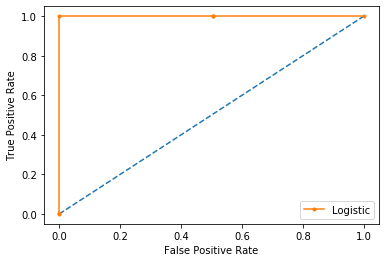

In [0]:
ns_probs = [0 for _ in range(len(y_test))]
xgbc_probs = xgbc.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgbc_probs = xgbc_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgbc_auc = roc_auc_score(y_test, xgbc_probs)
# summarize scores
print('XGBC: ROC AUC=%.3f' % (xgbc_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgbc_fpr, xgbc_tpr, _ = roc_curve(y_test, xgbc_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(xgbc_fpr, xgbc_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

**Preparing the prediction data is same steps as learning data**

In [0]:
df_A_B_prediction.shape

(5366, 80)

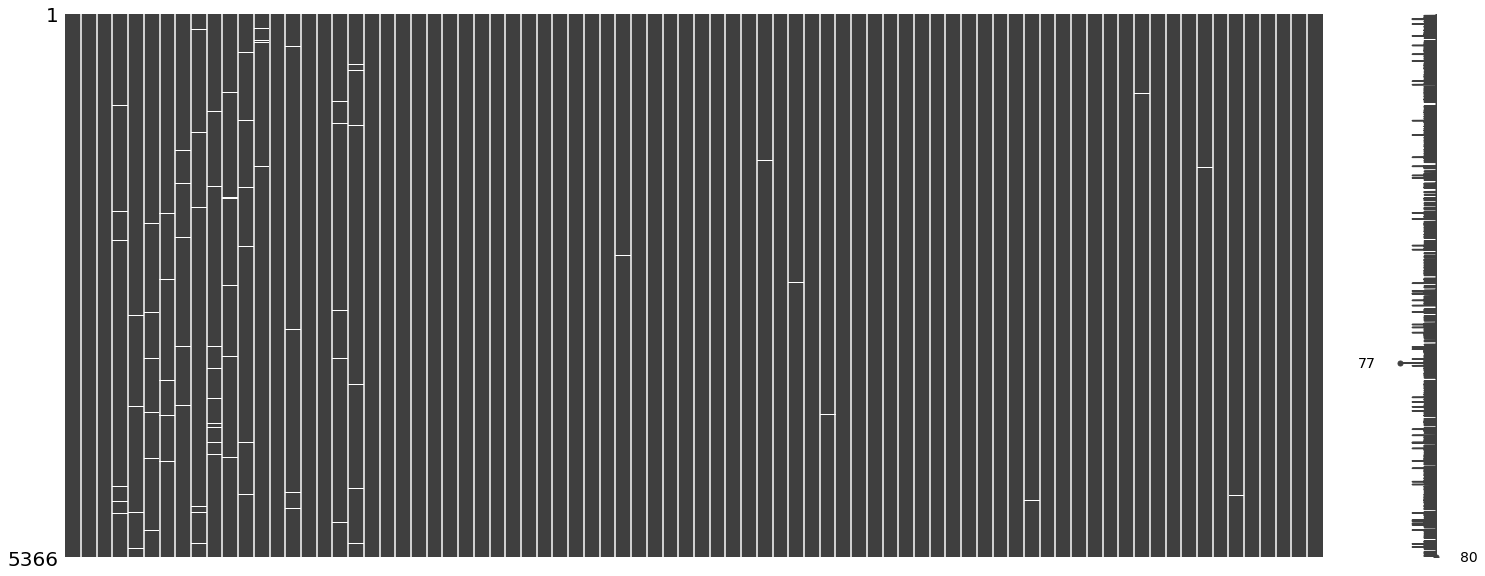

In [0]:
msno.matrix(df_A_B_prediction) 

In [121]:
df_A_B_prediction.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [122]:
df_A_B_prediction.select_dtypes('object').head()

,id,b00,b21,b34,b35,b58
0,6907-46,$-1464.28,Central,Wed.,-0.01,jul
1,9362-58,$2045.98,Central,Thursday,0.0,June
2,2687-18,$-499.39,Central,Wed.,0.01,jul
3,9826-18,2129.31,Central,Wednesday,-0.01 %,jul
4,7033-82,$ 1171.0,Central,Wednesday,0.01 %,jun


**Cleaning columns b00, b21, b34, b35, b58 of prediction data** 

In [123]:
df_A_B_prediction['b00'] = df_A_B_prediction['b00'].astype(str)

df_A_B_prediction['b00'] = df_A_B_prediction['b00'].str.replace(' ', '')
df_A_B_prediction['b00'] = df_A_B_prediction['b00'].str.replace('$', '')

df_A_B_prediction['b00'] = df_A_B_prediction['b00'].astype(float)

df_A_B_prediction['b00'].unique()

array([-1464.28,  2045.98,  -499.39, ...,   396.35,  -280.1 ,   490.12])

In [124]:
df_A_B_prediction.b21.unique()

array(['Central', 'West', 'East', nan], dtype=object)

In [125]:
df_A_B_prediction['b34'] = df_A_B_prediction['b34'].astype(str)

df_A_B_prediction['b34'] = df_A_B_prediction['b34'].str.replace(' ', '')
df_A_B_prediction['b34'] = df_A_B_prediction['b34'].str.replace('.', '')

df_A_B_prediction['b34'].unique()

array(['Wed', 'Thursday', 'Wednesday', 'thu', 'wed', 'tuesday', 'Thu',
       'wednesday', 'Friday', 'thursday', 'Tue', 'Fri', 'friday', 'fri',
       'tue', 'Tuesday', 'thurday', 'wendsday', 'mon', 'Teusday',
       'Monday', 'nan', 'monday'], dtype=object)

In [126]:
df_A_B_prediction['b34'] = clean_weekdays(df_A_B_prediction['b34'],['Mon','mon','Monday'], 'monday')
df_A_B_prediction['b34'] = clean_weekdays(df_A_B_prediction['b34'],['Tuesday','tue','Tue','Teusday'], 'tuesday')
df_A_B_prediction['b34'] = clean_weekdays(df_A_B_prediction['b34'],['Wed','Wednesday','wed','Wendsday','wendsday'], 'wednesday')
df_A_B_prediction['b34'] = clean_weekdays(df_A_B_prediction['b34'],['thu','Thursday','Thu','thurday'], 'thursday')
df_A_B_prediction['b34'] = clean_weekdays(df_A_B_prediction['b34'],['Fri','fri','Friday'], 'friday')
df_A_B_prediction['b34'].unique()

array(['wednesday', 'thursday', 'tuesday', 'friday', 'monday', 'nan'],
      dtype=object)

In [127]:
df_A_B_prediction['b35'] = df_A_B_prediction['b35'].astype(str)

df_A_B_prediction['b35'] = df_A_B_prediction['b35'].str.replace(' ', '')
df_A_B_prediction['b35'] = df_A_B_prediction['b35'].str.replace('%', '')

df_A_B_prediction['b35'] = df_A_B_prediction['b35'].astype(float)

df_A_B_prediction.b35.unique()

array([-0.01,  0.  ,  0.01, -0.02,  0.02,  0.03, -0.03,  0.04, -0.04])

In [128]:
df_A_B_prediction['b58'] = df_A_B_prediction['b58'].astype(str)

df_A_B_prediction['b58'] = df_A_B_prediction['b58'].str.replace(' ', '')
df_A_B_prediction['b58'] = df_A_B_prediction['b58'].str.replace('.', '')

df_A_B_prediction.b58.unique()

array(['jul', 'June', 'jun', 'august', 'aug', 'August', 'Sep', 'june',
       'Apr', 'April', 'May', 'Jun', 'oct', 'may', 'Oct', 'sep',
       'october', 'apr', 'Aug', 'april', 'september', 'sept', 'march',
       'March', 'mar', 'Nov', 'Sept', 'February', 'January', 'October',
       'November', 'Apirl', 'Mar', 'December', 'Dec', 'nov', 'Jan', 'nan',
       'november', 'feb'], dtype=object)

In [129]:
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['jan','January','Jan'], 'january')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['feb','Feb','February'], 'february')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['March','Mar','mar','Marhc'], 'march')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['April','apr','Apr','Apirl'], 'april')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['May'], 'may')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['June','Jun','jun'], 'june')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['jul'], 'july')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['August','aug','Aug','Augest'], 'august')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['sept','sep','Sept','Sep'], 'september')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['Oct','oct','October'], 'october')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['Nov','November','nov'], 'november')
df_A_B_prediction['b58'] = clean_months(df_A_B_prediction['b58'],['dec','December','Dec'], 'december')

df_A_B_prediction['b58'].unique()

array(['july', 'june', 'august', 'september', 'april', 'may', 'october',
       'march', 'november', 'february', 'january', 'december', 'nan'],
      dtype=object)

**Fill missing numerical data**

In [0]:
numerical_columns = df_A_B_prediction.select_dtypes('float64','int64').columns.tolist()

In [0]:
df_prediction_clean = df_A_B_prediction.fillna(df_A_B_prediction[numerical_columns].mean())

**Convert categorical data to numeric 'dummy' variables**

In [132]:
df_prediction_clean = pd.get_dummies(df_prediction_clean, columns=['b21'])
df_prediction_clean.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'code',
       'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09',
       'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19',
       'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30',
       'b31', 'b32', 'b33', 'b34', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40',
       'b41', 'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50',
       'b51', 'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'b58', 'zip',
       'b21_Central', 'b21_East', 'b21_West'],
      dtype='object')

In [133]:
df_prediction_clean = pd.get_dummies(df_prediction_clean, columns=['b34'])
df_prediction_clean.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'code',
       'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09',
       'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19',
       'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30',
       'b31', 'b32', 'b33', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40', 'b41',
       'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50', 'b51',
       'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'b58', 'zip', 'b21_Central',
       'b21_East', 'b21_West', 'b34_friday', 'b34_monday', 'b34_nan',
       'b34_thursday', 'b34_tuesday', 'b34_wednesday'],
      dtype='object')

In [134]:
df_prediction_clean = pd.get_dummies(df_prediction_clean, columns=['b58'])
df_prediction_clean.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'code',
       'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09',
       'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19',
       'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30',
       'b31', 'b32', 'b33', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40', 'b41',
       'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50', 'b51',
       'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'zip', 'b21_Central',
       'b21_East', 'b21_West', 'b34_friday', 'b34_monday', 'b34_nan',
       'b34_thursday', 'b34_tuesday', 'b34_wednesday', 'b58_april',
       'b58_august', 'b58_december', 'b58_february', 'b58_january', 'b58_july',
       'b58_june', 'b58_march', 'b58_may', 'b58_nan', 'b58_november',
       'b58_october', 'b58_september'],
      dtype='object')

**Testing Multicollinearity**

In [135]:
get_interaction_corr(df_prediction_clean.corr(),.5)

b21_East, b21_Central: corr. = -0.5643600020978553
b21_West, b21_Central: corr. = -0.7905596460013689
b34_wednesday, b34_thursday: corr. = -0.9203984127132419


In [0]:
df_prediction_clean = df_prediction_clean.drop(['b34_wednesday', 'b21_Central'], axis=1)

**Prediction modeling**

In [0]:
X_pred_set = df_prediction_clean.drop(['id'],axis=1)

In [62]:
X_pred_set.shape

(5366, 96)

In [63]:
X.shape

(7515, 95)

**Fitting Logistic Regression to the full learning dataset**

In [140]:
lr_pred = LogisticRegression(C=1.0, class_weight='balanced', penalty='l2', solver='newton-cg')

lr_pred.fit(X, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [158]:
y_logreg_probabilities = lr_pred.predict_proba(X_pred_set)
y_logreg_probabilities

array([[0.67086438, 0.32913562],
       [0.49451022, 0.50548978],
       [0.5191937 , 0.4808063 ],
       ...,
       [0.3957422 , 0.6042578 ],
       [0.86972563, 0.13027437],
       [0.83894652, 0.16105348]])

In [159]:
y_logreg_p = lr_pred.predict(X_pred_set)
y_logreg_p

array([0, 1, 0, ..., 1, 0, 0])

In [0]:
lr_prob_list = y_logreg_probabilities.tolist()

In [147]:
df_logreg_predictions = pd.DataFrame(lr_prob_list, columns=['pred0' , 'Prediction'])
df_logreg_predictions = df_logreg_predictions.drop(['pred0'], axis=1)
df_logreg_predictions.head(3)

,Prediction
0,0.329136
1,0.505490
2,0.480806


In [148]:
lr_result = pd.concat([df_prediction_clean['id'], df_logreg_predictions], axis=1, sort=False)
lr_result.head(3)

,id,Prediction
0,6907-46,0.329136
1,9362-58,0.505490
2,2687-18,0.480806


**Export logistic regression result dataframe to csv file**

In [149]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
lr_result.to_csv('predictions_CoreyCoole_model_1.csv')
!cp predictions_CoreyCoole_model_1.csv "drive/My Drive/"

**Fitting XGB Classifier to the full learning set**

In [152]:
xgbc_pred = XGBClassifier(alpha=0, booster='gbtree', reg_lambda=1, max_depth=12, scale_pos_weight=10)

xgbc_pred.fit(X, y)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=None,
              silent=None, subsample=1, verbosity=1)

In [164]:
y_xgbc_probabilities = xgbc_pred.predict_proba(X_pred_set)
y_xgbc_probabilities

array([[0.9915377 , 0.00846228],
       [0.99609214, 0.00390784],
       [0.9757644 , 0.02423559],
       ...,
       [0.99524915, 0.00475086],
       [0.99560183, 0.00439817],
       [0.8012216 , 0.19877836]], dtype=float32)

In [163]:
y_xgbc_p = xgbc_pred.predict(X_pred_set)
y_xgbc_p

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
xgbc_prob_list = y_xgbc_probabilities.tolist()

In [161]:
df_xgbc_predictions = pd.DataFrame(xgbc_prob_list, columns=['pred0' , 'Prediction'])
df_xgbc_predictions = df_xgbc_predictions.drop(['pred0'], axis=1)
df_xgbc_predictions.head(3)

,Prediction
0,0.008462
1,0.003908
2,0.024236


In [162]:
xgbc_result = pd.concat([df_prediction_clean['id'], df_xgbc_predictions], axis=1, sort=False)
xgbc_result.head(3)

,id,Prediction
0,6907-46,0.008462
1,9362-58,0.003908
2,2687-18,0.024236


**Export XGBC result dataframe to csv file**

In [0]:
xgbc_result.to_csv('predictions_CoreyCoole_model_2.csv')
!cp predictions_CoreyCoole_model_2.csv "drive/My Drive/"